In [27]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Simulate cost-optimal electrical grid construction under different policies.

Code contains GridElements: Power Sources, Demands and Storage.  Grid
Elements are placed in different grid regions.  Grid regions are
separated from each other so only sources with grid_region_id == x can
power Demands with grid_region_id == x

The costs of constructing GridElements are based upon:
  nameplate_unit_cost: The cost to build one unit (e.g. Megawatt) of power.
  variable_unit_cost: The cost to provide one unit of power over time.
    (e.g. Megawatt-Hour)

The code simulates the grid over multiple time-slices.  e.g.  Hourly
over a one year period which would map to 24 * 365 = 8760 time-slices.

The code is based upon a linear-program which contains:

  - An objective which is to minimize costs.
  - Constraints which must be met before the solution can converge.
    - conserve_power_constraint: Ensure that sum(power[t]) >=
      demand[t] for all t in each grid-region

This code will work with any set of consistent units.  For the
purposes of documentation, the units chosen are:

  Power: Megawatts
  Time: Hours
  (Derived) Energy = Power * Time => Megawatt-Hours
  Cost: Dollars ($)
  CO2 Emissions: Tonnes

  (Derived) CO2 Emitted per Energy => Tonnes / Megawatt-Hours
  Carbon Tax: $ / Tonnes

"""


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import distutils.sysconfig as sysconfig
import grid_sim_linear_program as gslp
import gridsim.grid_sim_simple_example as gsse
import pandas as pd
from tqdm import tnrange
import copy

import os.path as osp

from ortools.linear_solver import pywraplp

### To-Do: Get input power and output power values for storage.

In [28]:
profiles_path = gsse.get_data_directory() + ['profiles', 'profiles_california.csv']
profiles_file = osp.join(*profiles_path)
profiles = pd.read_csv(profiles_file, index_col=0, parse_dates=True)
profiles.columns

Index(['DEMAND', 'SOLAR', 'WIND', 'COAL', 'COAL_CRYO', 'COAL_AMINE',
       'NUCLEAR'],
      dtype='object')

In [29]:
storage_path = gsse.get_data_directory() + ['costs', 'storage_costs.csv']
storage_file = osp.join(*storage_path)
storage = pd.read_csv(storage_file, index_col=0, parse_dates=True)
storage.columns

Index(['fixed', 'charge_efficiency', 'discharge_efficiency', 'charge_capital',
       'discharge_capital'],
      dtype='object')

In [60]:
hours_per_year = 24 * 365
annual_discount_rate = 0.06
lifetime_in_years = 30
fuel_cost = 4
#fuel_costs = range(2,15,1)
storage_nameplate_costs = [300,100,30,10,3,1,0.3,0.1,0.03]
runs = []

In [61]:
for storage_nameplate_cost in storage_nameplate_costs:
    print(storage_nameplate_cost)
    lp = gslp.LinearProgramContainer(profiles)
    lp.cost_of_money = gslp.extrapolate_cost(
          1.0,
          annual_discount_rate,
          lp.number_of_timeslices / hours_per_year,
          lifetime_in_years)
    lp.add_demands(gslp.GridDemand('DEMAND'))
    lp.add_dispatchable_sources(
        gslp.GridSource(
          name='NGCC',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=1239031,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=1.99+(6.20*fuel_cost),  # Cheap fuel costs assumes fracking. $/MWh                                                                               
          co2_per_electrical_energy=0.33,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False),
        gslp.GridSource(
          name='NGCT',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=770633.274099,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=10.64+(8.55*fuel_cost),  # Cheap fuel costs assumes fracking. $/MWh                                                                               
          co2_per_electrical_energy=0.453751127329,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False),
        gslp.GridSource(
          name='HYDRO',  # Dispatchable, so no name restriction.                                                                                                
          nameplate_unit_cost=217839.46,  # Cost for a combined cycle plant. $/MW                                                                              
          variable_unit_cost=2.66,# Cheap fuel costs assumes fracking. $/MWh  
          max_energy = 13808000,
          max_power = 9594.8,
          co2_per_electrical_energy=0,  # Tonnes CO2 / MWh                                                                                                
          is_rps_source=False))  # Not in Renewable Portfolio Standard. )  # Not in Renewable Portfolio Standard.))
    # Add non-dispatchable resources.
    lp.add_nondispatchable_sources(gslp.GridSource(
          name='COAL',  # Matches profile column name for nondispatch.                                                                                      
          nameplate_unit_cost=454938.6814+2934000,  # Aggressive wind cost $/MW                                                                                          
          variable_unit_cost=23.302,                                                                                                             
          co2_per_electrical_energy=0.85819676404,                                                                                                      
          is_rps_source=False),
        gslp.GridSource(
          name='WIND',  # Matches profile column name for nondispatch.                                                                                      
          nameplate_unit_cost= (1.50+681.4989)*1000000,  #2181532.57887,  # Aggressive wind cost $/MW                                                                                          
          variable_unit_cost=0,  # No fuel cost.                                                                                                             
          co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
          is_rps_source=True),  # In Renewable Portfolio Standard )
        gslp.GridSource(
          name='SOLAR',  # Matches profile column name for nondispatch.                                                                                      
          nameplate_unit_cost= (1.04+316.0194)*1000000,   #1356035.01731,                                                                                        
          variable_unit_cost=0,  # No fuel cost.                                                                                                             
          co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
          is_rps_source=True),  # In Renewable Portfolio Standard )
        gslp.GridSource(
          name='NUCLEAR',  # Matches profile column name for nondispatch.                                                                                      
          nameplate_unit_cost=1167257.6816463014+3500000,  # Aggressive wind cost $/MW                                                                                          
          variable_unit_cost=12.0,  # No fuel cost.                                                                                                             
          co2_per_electrical_energy=0,  # Clean energy.                                                                                                      
          is_rps_source=False))  #In Renewable Portfolio Standar
    lp.add_storage(gslp.GridStorage(
          name=storage.index[1],  # ELECTROCHEMICAL                                                                                      
          storage_nameplate_cost= storage_nameplate_cost *1000 *1.87, #storage.loc[1,'fixed'],  # Aggressive wind cost $/MW                                                                                          
          charge_nameplate_cost= storage.iloc[1]['charge_capital'],
          discharge_nameplate_cost= storage.iloc[1]['discharge_capital'],
          charge_efficiency= storage.iloc[1]['charge_efficiency'],
          discharge_efficiency= storage.iloc[1]['discharge_efficiency'],
          max_charge_power=-1,
          max_discharge_power=-1,
          max_storage=-1,
          is_rps=True))
    
    lp.carbon_tax = 0 # No Carbon Tax
    lp.rps_percent = 90 # 90% solar + wind

    
    lp.solve()
    runs.append(copy.copy(lp))


        

300
100
30
10
3
1
0.3
0.1
0.03


### Loop through runs, plot capacity breakdowns for each natural gas fuel cost.

In [10]:
# resources = [runs[0].sources[i].name for i in range(len(runs[0].sources))]

# resource_capacity_lists = {}
# for resource in resources:
#     resource_capacity_lists[resource] = []
    
# resource_gen_lists = {}
# for resource in resources:
#     resource_gen_lists[resource] = [] 

In [11]:
# for lp in runs:
#     resources= lp.sources
    
#     capacity_fractions = {}
#     total_capacity = 0
#     for resource in resources:
#         total_capacity = total_capacity + resource.get_nameplate_solution_value()  
#     for resource in resources:
#         fraction_capacity = resource.get_nameplate_solution_value() / total_capacity
#         capacity_fractions[resource.name] = fraction_capacity 
#     capacity_breakdown = capacity_fractions
    
#     for resource in resources:
#         capacity = capacity_breakdown[resource.name]
#         resource_capacity_lists[resource.name].append(capacity)
    
    
#     gen_breakdown = runs[key].gen_results()
#     for resource in resources:
#         gen = gen_breakdown[resource]
#         resource_gen_lists[resource].append(gen) 

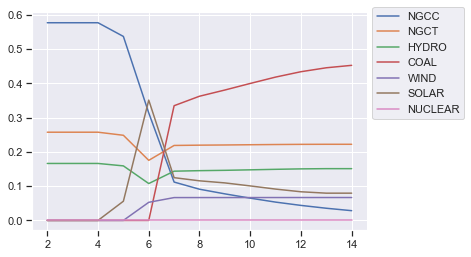

In [12]:
# lines = []
# fig, ax = plt.subplots()
# for resource in resources:
#     capacity_line = resource_capacity_lists[resource.name]
#     plt.plot(fuel_costs, capacity_line, label = str(resource.name)) 

# sns.set()
# ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')

### Loop through runs to plot storage capacity (MWh) and input and output power.

In [45]:
storage_lines = {}
capacity_line = []
input_power_line = []
output_power_line = []

peak_demand = max(profiles.DEMAND)

for lp in runs:
    storage_nameplate_energy = lp.storage[0].get_nameplate_solution_value() 
    capacity_ratio = storage_nameplate_energy / peak_demand
    capacity_line.append(capacity_ratio)
    
    storage_input_power = lp.storage[0].sink.get_nameplate_solution_value()
    input_power_ratio = storage_input_power / peak_demand
    input_power_line.append(input_power_ratio)
    
    storage_output_power = lp.storage[0].source.get_nameplate_solution_value()
    output_power_ratio = storage_output_power / peak_demand
    output_power_line.append(output_power_ratio)
    
storage_lines['Capacity (hours of peak demand)']=capacity_line
storage_lines['Input Power']= input_power_line
storage_lines['Output Power']= output_power_line


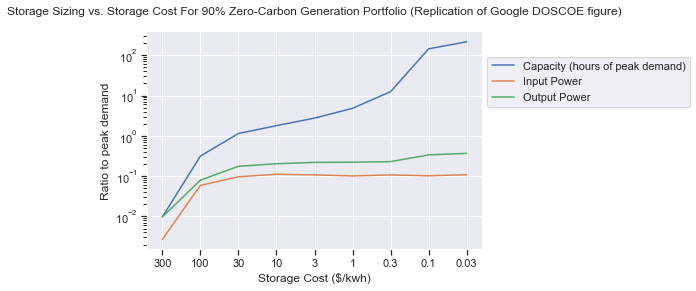

In [59]:
lines = ['Capacity (hours of peak demand)','Input Power', 'Output Power']
n = len(storage_nameplate_costs)
a = np.arange(n)

fig, ax = plt.subplots()
for line in lines:
    storage_line = storage_lines[line]
    plt.plot(a.astype(str), storage_line, label = line) 

sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_ticks(a) #set the ticks to be a
ax.xaxis.set_ticklabels(storage_nameplate_costs) # change the ticks' names to x

# ylength = len(storage_line)
# b = np.arange(ylength)
# ax.yaxis.set_ticks(b)
#ax.yaxis.set_ticklabels(storage_nameplate_costs) # change the ticks' names to y

ax.set_yscale('log')
#ax.invert_yaxis()

ax.set_xlabel('Storage Cost ($/kwh)')
ax.set_ylabel('Ratio to peak demand')
ax.set_title('Storage Sizing vs. Storage Cost For 90% Zero-Carbon Generation Portfolio (Replication of Google DOSCOE figure)').set_position([.5, 1.05])

In [7]:
# for i,lp in enumerate(runs):
#     fuel_cost = fuel_costs[i]
#     print('fuel cost = ' + str(fuel_cost), runs[i].sources[1].name, str(runs[i].sources[1].get_nameplate_solution_value()))

In [6]:
# for i,lp in enumerate(runs):
#     fuel_cost = fuel_costs[i]
#     print('fuel cost = ' + str(fuel_cost), runs[i].sources[0].name, str(runs[i].sources[0].get_nameplate_solution_value()))